<a href="https://colab.research.google.com/github/b-remy/score-estimation-comparison/blob/master/notebooks/Denoiser_haiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet git+https://github.com/deepmind/dm-haiku

In [3]:
%pylab inline 

import numpy as onp
import jax
import jax.numpy as jnp
from jax.experimental import optix
import haiku as hk
import tensorflow_probability as tfpp; tfp = tfpp.experimental.substrates.jax
from functools import partial

tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


In [4]:
# This code is taken from make_moons in sklearn
resolution = 1024
outer_circ_x = jnp.cos(jnp.linspace(0, jnp.pi, resolution))
outer_circ_y = jnp.sin(jnp.linspace(0, jnp.pi, resolution))
inner_circ_x = 1 - jnp.cos(jnp.linspace(0, jnp.pi, resolution))
inner_circ_y = 1 - jnp.sin(jnp.linspace(0, jnp.pi, resolution)) - .5

X = jnp.append(outer_circ_x, inner_circ_x)
Y = jnp.append(outer_circ_y, inner_circ_y)
coords = jnp.vstack([X,Y])

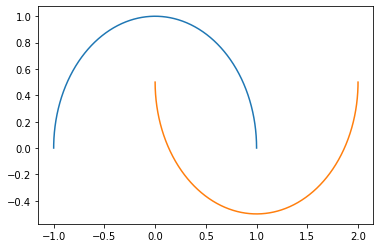

In [5]:
plot(outer_circ_x,outer_circ_y)
plot(inner_circ_x,inner_circ_y)

In [6]:
sigma=0.02

# We approximate the 2 moons with a large mixture
distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=np.ones(2*resolution)/resolution/2),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=coords.T, scale_identity_multiplier=sigma) 
)

coords.T.shape

(2048, 2)

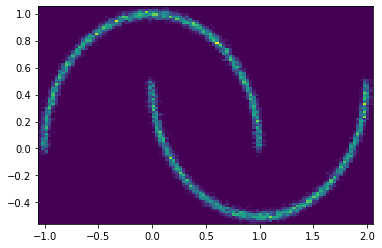

In [7]:
rng_key = jax.random.PRNGKey(seed=0)
samps = distribution.sample(10000, seed=rng_key)

# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

In [8]:
# But now we can also compute the gradients of log p :-)
score = jax.vmap(jax.grad(distribution.log_prob))

In [9]:
score(np.array([0.,0.]).reshape([1,2]))

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


DeviceArray([[264.3321 , 132.16592]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


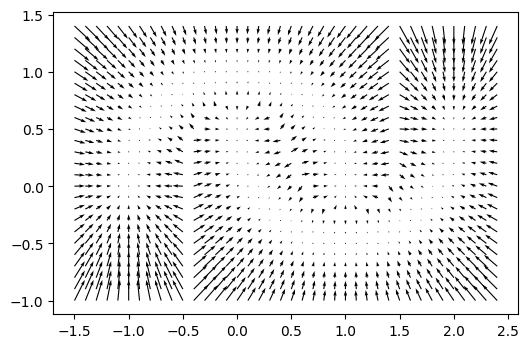

In [10]:
figure(dpi=100)
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


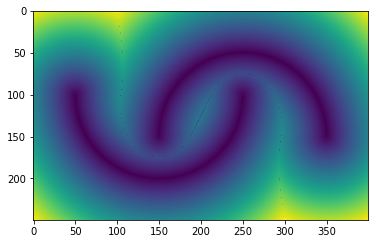

In [11]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1., 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = score(points).reshape([len(Y), len(X),2])

imshow(sqrt(g[:,:,0]**2 + g[:,:,1]**2))

**Implement a denoiser**

In [12]:
class Denoiser(hk.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
    
    def __call__(self, x, is_training):
        # Encoder
        net = hk.Linear(128)(x)
        net = hk.BatchNorm(True, True, 0.9)(net, is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)
        
        # Decoder
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)
        
        return net

In [13]:
def forward(x, is_training):
    denoiser = Denoiser()
    return denoiser(x, is_training)
             
model = hk.transform_with_state(forward)

In [14]:
batch_size = 512
step_size = 0.05

def get_batch(rng_key):
    dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            probs=np.ones(2*resolution)/resolution/2),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=coords.T, scale_identity_multiplier=sigma)
    )
    
    y = distribution.sample(batch_size, seed=rng_key)
    x = y + step_size * onp.random.randn(batch_size, 2)
    
    # x is a noisy sample, y is a sample from the distribution
    return {'x':x, 'y':y}

In [15]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [16]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model.apply(params, state, rng_key, batch['x'], is_training=True)
    ypred = batch['x'] + res
    loss = jnp.mean((ypred - batch['y'])**2)
    return loss, state

In [17]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [18]:
params, state = model.init(next(rng_seq), jnp.zeros((1, 2)), is_training=True)
opt_state = optimizer.init(params)

In [19]:
losses = []
for step in range(5000):
    batch = get_batch(next(rng_seq))
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.0588582
100 0.0027393023
200 0.0028027971
300 0.00244385
400 0.0022114576
500 0.0024771153
600 0.0020429906
700 0.0025117164
800 0.0022252495
900 0.0024098589
1000 0.0017017543
1100 0.002232493
1200 0.0018319356
1300 0.0021728799
1400 0.0021430366
1500 0.0020011372
1600 0.001778218
1700 0.0017194977
1800 0.0019765757
1900 0.0018631504
2000 0.0020044758
2100 0.0018944147
2200 0.001797865
2300 0.0019178882
2400 0.0017817535
2500 0.0017604865
2600 0.0017610885
2700 0.001557429
2800 0.0017966997
2900 0.0017471882
3000 0.0023593646
3100 0.0016902706
3200 0.0017387612
3300 0.0016554301
3400 0.0017607274
3500 0.0018741318
3600 0.0018359127
3700 0.0017881567
3800 0.0017739217
3900 0.0016711431
4000 0.0018119753
4100 0.0016679689
4200 0.001739549
4300 0.0016881714
4400 0.0015646716
4500 0.0016084213
4600 0.0016415099
4700 0.0020425695
4800 0.0016506815
4900 0.0016151263


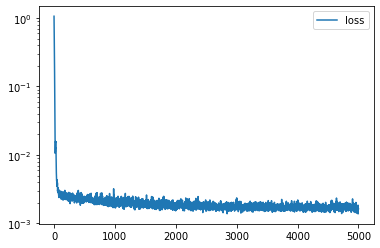

In [20]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [21]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

score = partial(model.apply, params, state, next(rng_seq))

In [22]:
res, state = score(points, is_training=False)

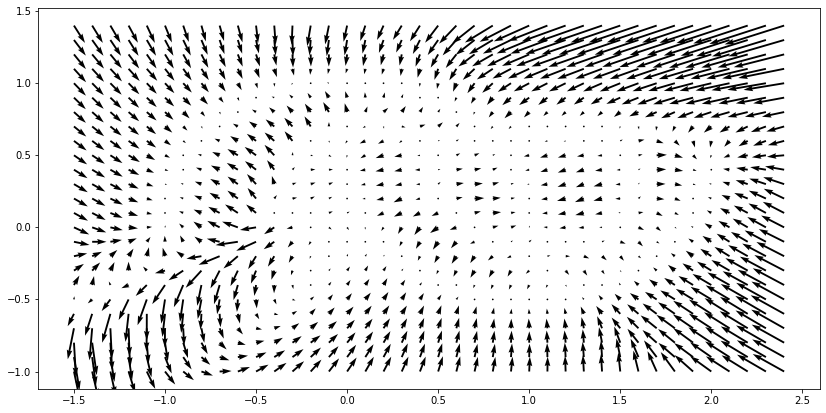

In [23]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

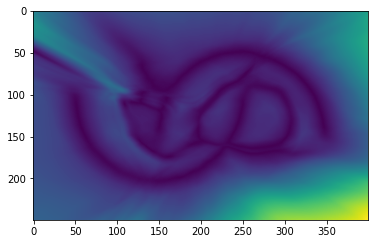

In [24]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = score(points, is_training=False)
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))